# UFO Sightings Data Exploration

This notebook explores UFO sightings data using SQL and visualizations in Python.

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd

# Load environment variables (if using dotenv)
load_dotenv()

# Retrieve environment variables
POSTGRES_USER = os.getenv('POSTGRES_USER')
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')
POSTGRES_HOST = os.getenv('POSTGRES_HOST')
POSTGRES_PORT = os.getenv('POSTGRES_PORT')
POSTGRES_DB = os.getenv('POSTGRES_DB')


## Database Connection

In [2]:
# Create the database connection string
connection_string = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"

# Create an SQLAlchemy engine
engine = create_engine(connection_string)


## Data Loading

In [3]:
df = pd.read_sql("SELECT * FROM ufo_sightings LIMIT 10", engine)
df.head()

,id,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date_posted,latitude,longitude
0,1,1949-10-10 20:30:00,San Marcos,TX,US,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111
1,2,1955-10-10 17:00:00,Chester (Uk/England),NaN,GB,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667
2,3,1956-10-10 21:00:00,Edna,TX,US,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833
3,4,1960-10-10 20:00:00,Kaneohe,HI,US,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611
4,5,1961-10-10 19:00:00,Bristol,TN,US,sphere,300.0,5 minutes,My father is now 89 my brother 52 the girl wit...,2007-04-27,36.595000,-82.188889


## Data Summary

In [4]:
# Get summary statistics
df.describe()

# Get data types
df.dtypes

id                             int64
datetime              datetime64[ns]
city                          object
state                         object
country                       object
shape                         object
duration_seconds             float64
duration_hours_min            object
comments                      object
date_posted                   object
latitude                     float64
longitude                    float64
dtype: object

## State-wise UFO Sightings

In [5]:
state_counts = pd.read_sql("SELECT state, COUNT(*) as sightings_count FROM ufo_sightings GROUP BY state ORDER BY sightings_count DESC", engine)
state_counts

,state,sightings_count
0,CA,9476
1,WA,4245
2,FL,4118
3,TX,3689
4,NY,3196
...,...,...
63,NF,16
64,PE,14
65,YT,8
66,DC,8


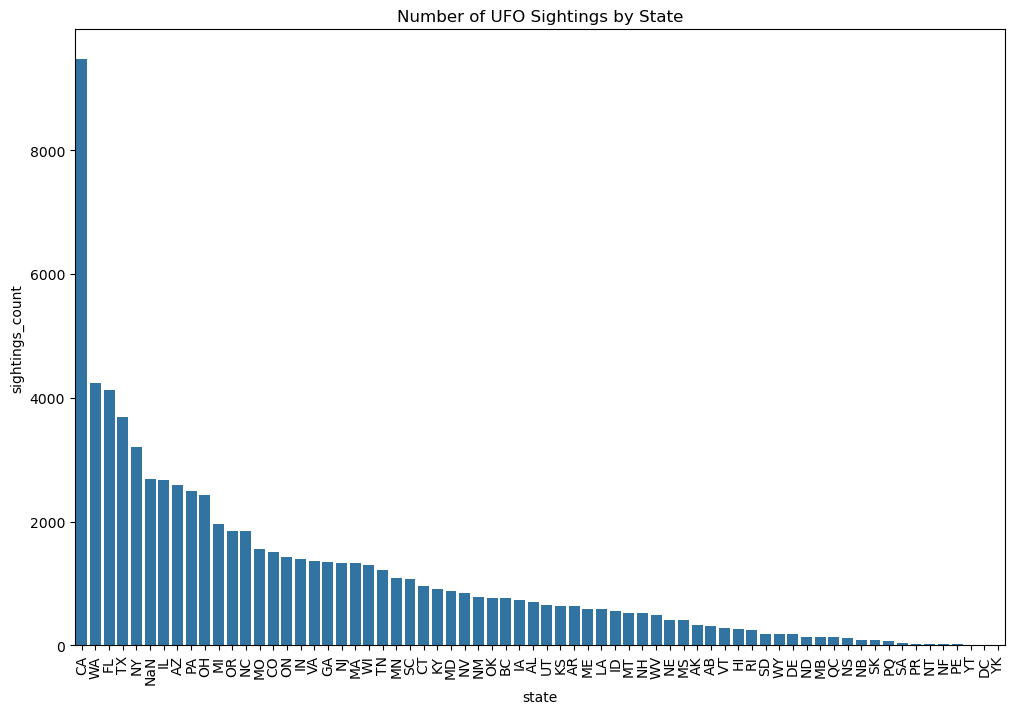

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='state', y='sightings_count', data=state_counts)
plt.xticks(rotation=90)
plt.title('Number of UFO Sightings by State')
plt.show()

## Temporal Analysis

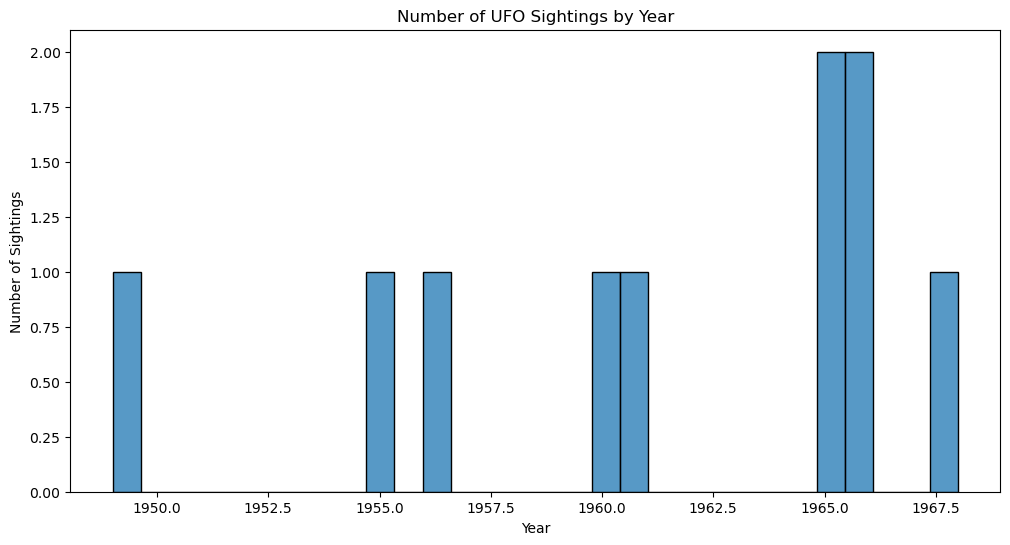

In [7]:
# Extract the year from the datetime column
df['year'] = pd.to_datetime(df['datetime']).dt.year

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['year'], bins=30, kde=False)
plt.title('Number of UFO Sightings by Year')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.show()


## Geographic Distribution of UFO Sightings

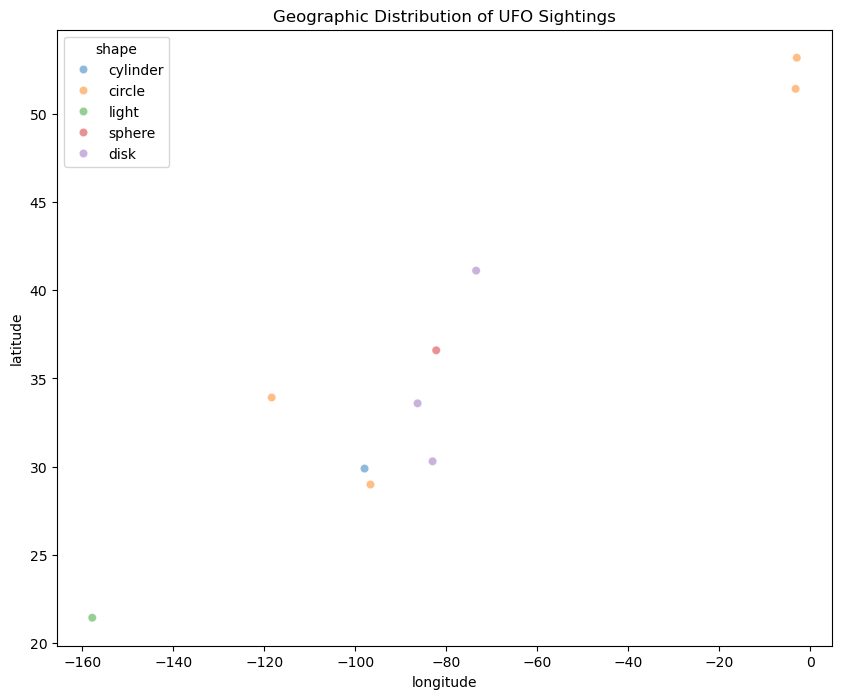

In [8]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='shape', alpha=0.5)
plt.title('Geographic Distribution of UFO Sightings')
plt.show()


<Figure size 1000x600 with 0 Axes>

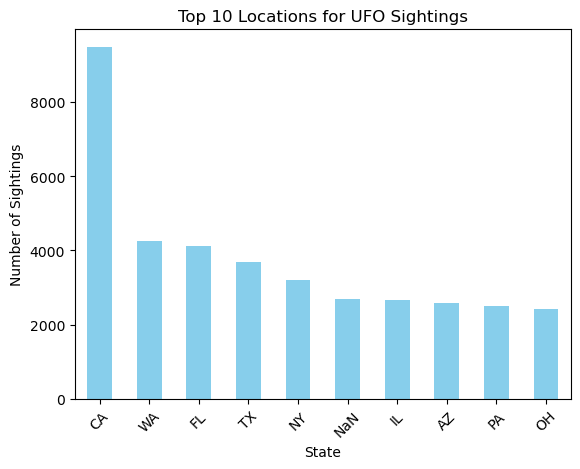

In [10]:
# Where are UFOs most frequently sighted?

from sqlalchemy import MetaData, Table, select, func, desc
import matplotlib.pyplot as plt

# Where are UFOs most frequently sighted?

# Reflect the table from the database
metadata = MetaData()
ufo_sightings_table = Table('ufo_sightings', metadata, autoload_with=engine)

# Query to get the most frequent UFO sightings by state
query = (
    select(
        ufo_sightings_table.c.state,
        func.count().label('sighting_count')
    )
    .group_by(ufo_sightings_table.c.state)
    .order_by(desc('sighting_count'))
    .limit(10)
)

# Execute the query and load the results into a DataFrame
location_counts = pd.read_sql(query, engine)

# Plotting the top locations
plt.figure(figsize=(10, 6))
location_counts.plot(kind='bar', x='state', y='sighting_count', color='skyblue', legend=False)
plt.title('Top 10 Locations for UFO Sightings')
plt.xlabel('State')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.show()

## Detailed Temporal Trends in UFO Sightings

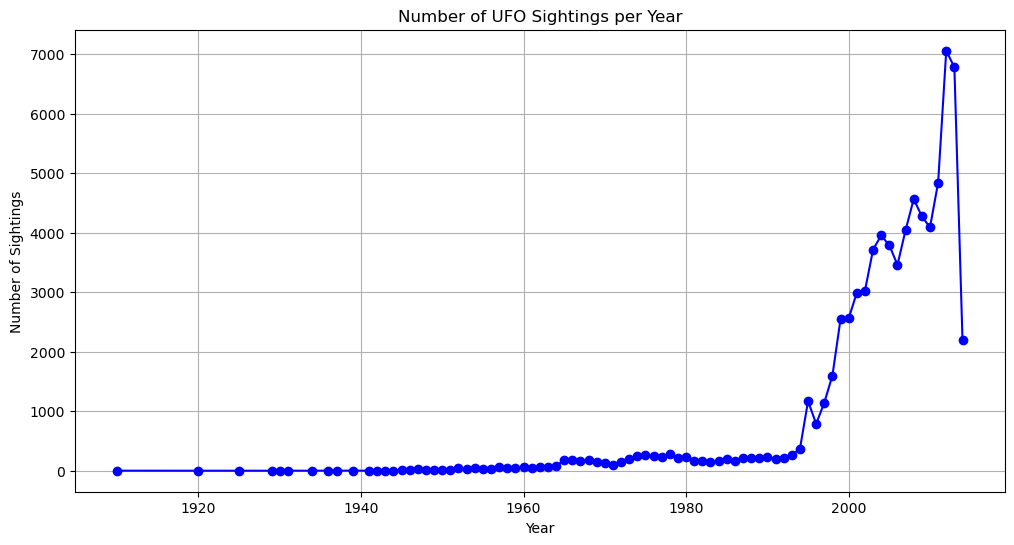

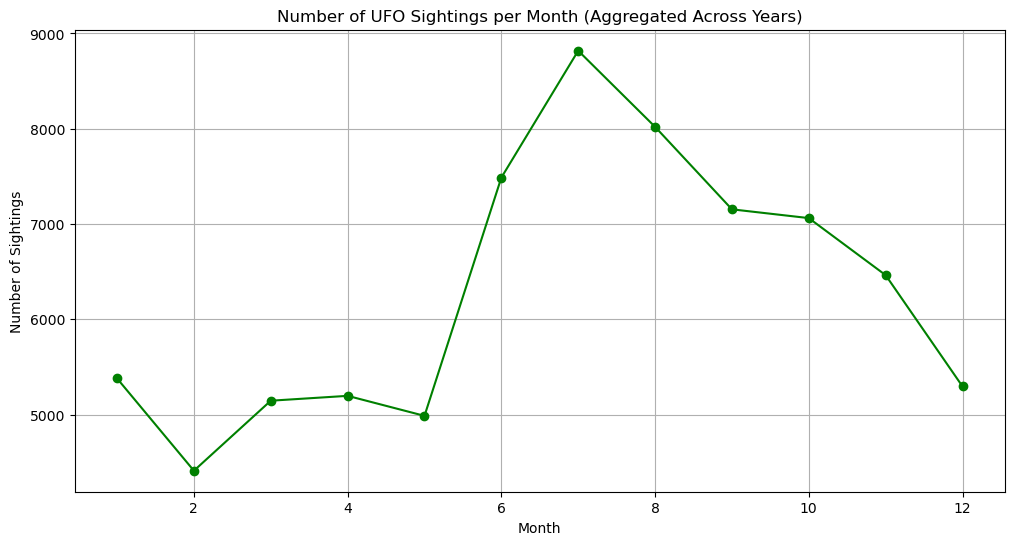

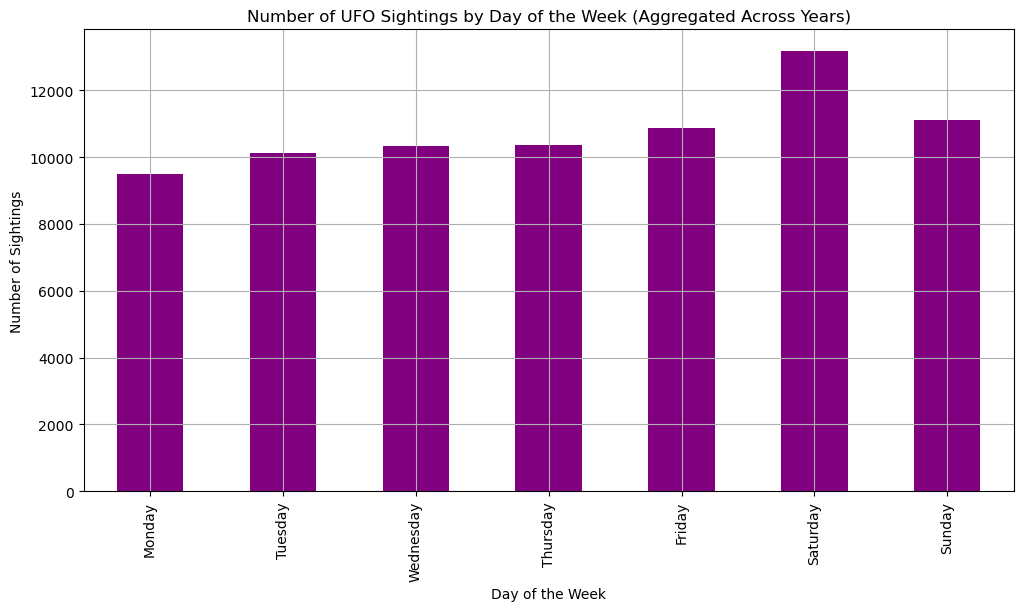

In [9]:
from sqlalchemy import MetaData, Table, select

# Reflect the table
metadata = MetaData()
ufo_sightings_table = Table('ufo_sightings', metadata, autoload_with=engine)

# Query to get the datetime of sightings
query = select(ufo_sightings_table.c.datetime)

# Execute the query and load the results into a DataFrame
sightings = pd.read_sql(query, engine)

# Convert the 'datetime' column to a pandas datetime object
sightings['datetime'] = pd.to_datetime(sightings['datetime'])

# Extract relevant time components
sightings['year'] = sightings['datetime'].dt.year
sightings['month'] = sightings['datetime'].dt.month
sightings['day'] = sightings['datetime'].dt.day
sightings['day_of_week'] = sightings['datetime'].dt.day_name()

# Aggregate the data by year
yearly_trend = sightings.groupby('year').size()

# Plotting the trend over years
plt.figure(figsize=(12, 6))
yearly_trend.plot(kind='line', color='blue', marker='o')
plt.title('Number of UFO Sightings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.grid(True)
plt.show()

# Aggregate the data by month over all years
monthly_trend = sightings.groupby('month').size()

# Plotting the trend over months
plt.figure(figsize=(12, 6))
monthly_trend.plot(kind='line', color='green', marker='o')
plt.title('Number of UFO Sightings per Month (Aggregated Across Years)')
plt.xlabel('Month')
plt.ylabel('Number of Sightings')
plt.grid(True)
plt.show()

# Aggregate the data by day of the week over all years
weekly_trend = sightings.groupby('day_of_week').size()

# Sort the days of the week in the correct order
weekly_trend = weekly_trend.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotting the trend over days of the week
plt.figure(figsize=(12, 6))
weekly_trend.plot(kind='bar', color='purple')
plt.title('Number of UFO Sightings by Day of the Week (Aggregated Across Years)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sightings')
plt.grid(True)
plt.show()


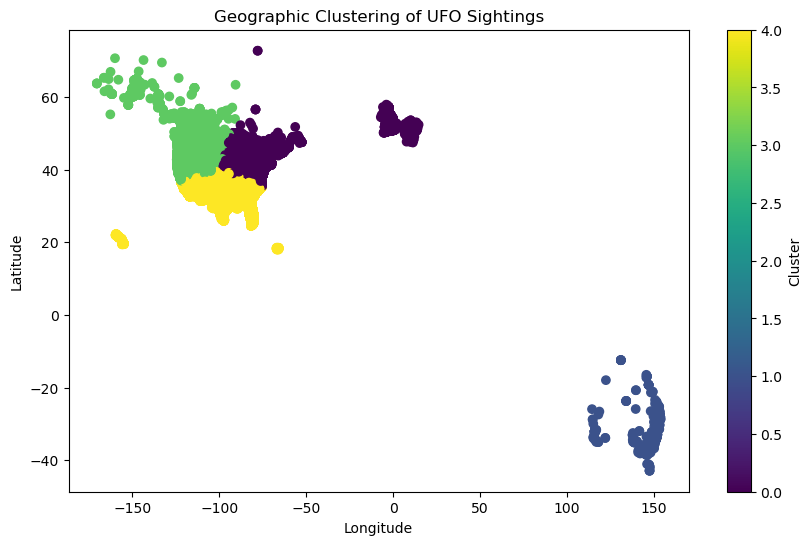

In [11]:
from sqlalchemy import MetaData, Table, select
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 7) Clustering techniques to find patterns

# Reflect the table from the database
metadata = MetaData()
ufo_sightings_table = Table('ufo_sightings', metadata, autoload_with=engine)

# Query to get the latitude, longitude, and duration of sightings
query = select(
    ufo_sightings_table.c.latitude,
    ufo_sightings_table.c.longitude,
    ufo_sightings_table.c.duration_seconds
)

# Execute the query and load the results into a DataFrame
sightings = pd.read_sql(query, engine)

# Drop any rows with missing or invalid data
sightings = sightings.dropna()

# Scale the data (important for K-Means clustering)
scaler = StandardScaler()
sightings_scaled = scaler.fit_transform(sightings[['latitude', 'longitude', 'duration_seconds']])

# Choose the number of clusters (you can adjust this)
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the K-Means model
kmeans.fit(sightings_scaled)

# Add the cluster labels to the original DataFrame
sightings['cluster'] = kmeans.labels_

# Visualize the clusters (latitude vs. longitude)
plt.figure(figsize=(10, 6))
plt.scatter(sightings['longitude'], sightings['latitude'], c=sightings['cluster'], cmap='viridis', marker='o')
plt.title('Geographic Clustering of UFO Sightings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

In [13]:
# Query to get all columns from the ufo_sightings table
query = select(ufo_sightings_table)

# Execute the query and load the results into a DataFrame
sightings = pd.read_sql(query, engine)

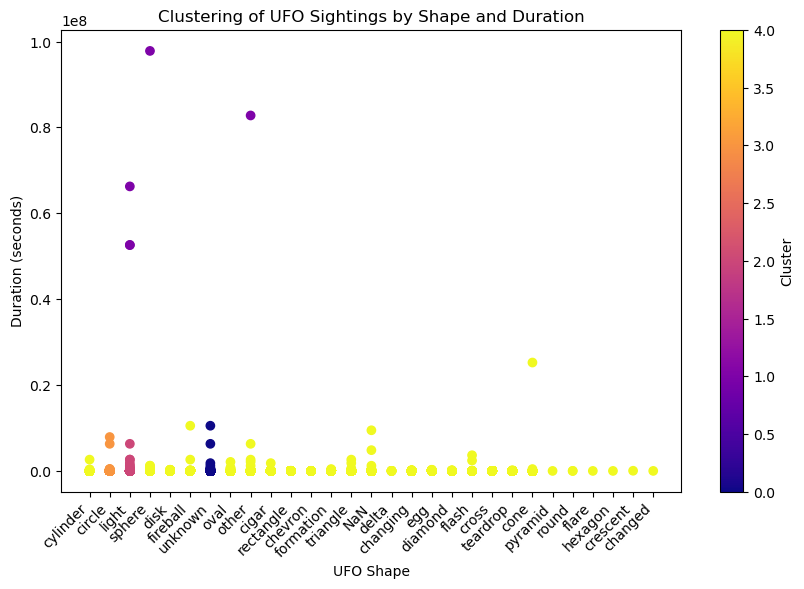

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Ensure all column names are strings
sightings.columns = sightings.columns.map(str)

# Select the features for clustering, including 'shape' explicitly as a categorical variable
features = sightings[['shape', 'duration_seconds']]

# Define the column transformer to apply one-hot encoding to 'shape' and standard scaling to 'duration_seconds'
column_transformer = ColumnTransformer(
    transformers=[
        ('shape_onehot', OneHotEncoder(), ['shape']),
        ('duration_scaler', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', StandardScaler())
        ]), ['duration_seconds'])
    ]
)

# Create a pipeline to apply the transformations and then fit the KMeans model
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('kmeans', KMeans(n_clusters=5, random_state=42))
])

# Fit the KMeans model
pipeline.fit(features)

# Add the cluster labels to the original DataFrame
sightings['shape_duration_cluster'] = pipeline.named_steps['kmeans'].labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(sightings['shape'], sightings['duration_seconds'], c=sightings['shape_duration_cluster'], cmap='plasma')
plt.title('Clustering of UFO Sightings by Shape and Duration')
plt.xlabel('UFO Shape')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45, ha='right')
plt.colorbar(label='Cluster')
plt.show()

In [27]:
# Additional Questions

## Are there specific weather conditions associated with increased UFO sightings?
## How do UFO sighting reports correlate with periods of social or political unrest?
## Are there any trends in the types of UFOs reported over time?
## How do UFO sighting reports correlate with periods of increased media coverage on UFOs?
## How do the descriptions of UFOs differ between different cultural or linguistic groups?
## Are there any commonalities in the physical or psychological characteristics of witnesses?
## How do UFO sightings correlate with the proximity to natural disaster zones?
## How do UFO sightings correlate with periods of increased space exploration activity?
## What are the most common descriptions of sound associated with UFO sightings?
## What are the most common physical locations (e.g., roads, fields) where UFOs are sighted?
## What are the most frequently reported emotions or psychological effects experienced by witnesses during UFO sightings?
